## 4 - Velocity Basics

In this notebook, we will show how to calculate and visualise plate velocity data with GPlately. You will need to have Plate Tectonic Tools (https://github.com/EarthByte/PlateTectonicTools/tree/master/ptt) downloaded to your system. 

Let's import all needed packages:

In [1]:
import gplately

import numpy as np
import pygplates
import ptt
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

Let's first create a plate motion model using GPlately's `PlateReconstruction` object. To create the object, we need to pass a `rotation_model`, a set of pygplates `topology_features` and a path to a `static_polygons` file, which we will obtain from the Muller et al. (2019) plate model using GPlately's `DataServer` object.

In [2]:
# Initialise GPlately data server and download Muller et al. 2019 files
gdownload = gplately.download.DataServer("Muller2019")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

We will need this plate model to call GPlately's `PlotTopologies` object. Let's again download Muller et al. (2019) `coastlines`, `continents` and `COBs` using GPlately's `DataServer` object.

In [3]:
# Reconstruction time
time = 50 # Ma

# Obtain geometries with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

### Calculating velocity data for a plate model

Let's calculate plate velocity data for the `Muller2019` model using `get_point_velocities`, a method in the `PlateReconstruction` object. It returns the north and east components of velocities for each point that we give it. 

`get_point_velocities` needs the following parameters:
- 2 1d flattened meshnode arrays representing the latitudinal and longitudinal extent of the velocity domain feature; 
- the reconstruction time (Ma);
- the time interval (Ma) with which to generate partitioning plate stage rotations (every millionth year by default, which is what we'll use)

It returns a list with lists containing the north and east components of velocity for each point in the velocity domain feature at 50Ma. 

In [4]:
# Let's span our lat-lon arrays across the entire globe with 5-degree spacing
Xnodes = np.arange(-180,180,5)
Ynodes = np.arange(-90,90,5)

# Generate the meshnode point feature and flatten back into 1d lat-lon arrays
x,y = np.meshgrid(Xnodes,Ynodes)
x = x.flatten()
y = y.flatten()

# Call the GPlately function to get point velocities!
time = 50 # Ma
all_velocities = model.get_point_velocities(x, y, time, delta_time=1.0)

print('Each list contains the north and east velocity components:')
print(all_velocities)
print('Number of lists containing velocity data = ', len(all_velocities))
print('Number of points in our velocity domain = ', len(x))

Each list contains the north and east velocity components:
[[ -3.87083921  -1.89315628]
 [ -3.87083921  -1.89315628]
 [ -3.87083921  -1.89315628]
 ...
 [-27.25261405  20.46778238]
 [-29.15923534  18.01416028]
 [-30.84393725  15.4043343 ]]
Number of lists containing velocity data =  2592
Number of points in our velocity domain =  2592


The magnitude of plate velocity (cm/yr) is the hypotenuse of these components.

In [5]:
random_point_in_domain = 326
vel_mag = np.hypot(all_velocities[random_point_in_domain][0], all_velocities[random_point_in_domain][1])
print('Average speed (cm/yr): ', vel_mag)

Average speed (cm/yr):  4.140850754834013


### Plotting velocity vector arrow fields
As a first example, let's reconstruct all topological plates and boundaries to 50Ma and illustrate the velocity of each moving plate! One way to do this is by plotting a velocity vector field using the `plot_plate_motion_vectors` method on the `PlotTopologies` object.

Since `plot_plate_motion_vectors` uses Cartopy's `quiver` function, it accepts `quiver` keyword arguments like `regrid_shape`. This is useful if you'd like your vectors interpolated onto a regular grid in projection space.

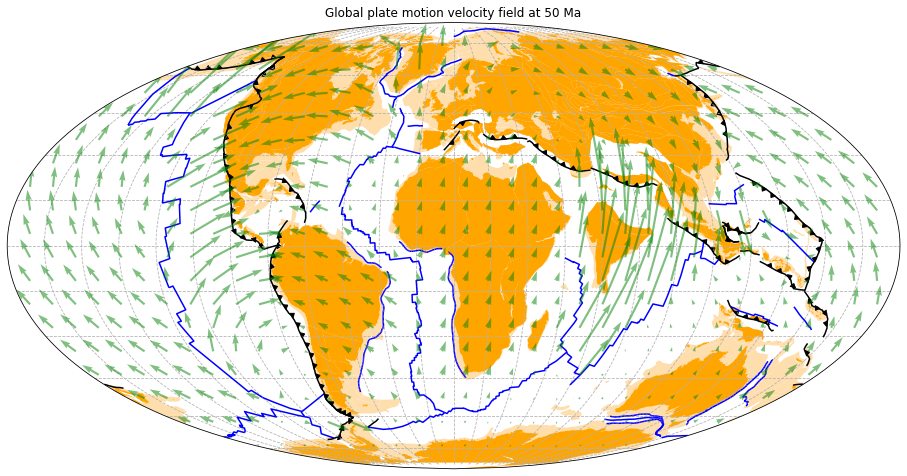

In [6]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
ax1.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.title('Global plate motion velocity field at %i Ma' % (time))

# Plot all topologies
gplot.plot_continents(ax1, facecolor='navajowhite')
gplot.plot_coastlines(ax1, color='orange')
gplot.plot_ridges_and_transforms(ax1, color='b')
gplot.plot_trenches(ax1, color='k')
gplot.plot_subduction_teeth(ax1, color='k')
ax1.set_global()

# Plot a veloctiy vector field on both maps
gplot.plot_plate_motion_vectors(ax1, regrid_shape=20, alpha=0.5, color='green', zorder=2)

### Visualising the data in `all_velocities` 

You can visualise the data in `all_velocities` in many ways. To do this, we'll need 4 parameters: 
- __Xnodes__: The longitudinal extent of the velocity domain feature;
- __Ynodes__: The latitudinal extent of the velocity domain feature;
- __u__: the east velocity components reshaped to fit the velocity domain feature
- __v__: the north velocity components reshaped to fit the velocity domain feature

We create them below:

In [7]:
# Set the longitudinal and latitudinal extent of the velocity domain feature
Xnodes = np.arange(-180,180,5)
Ynodes = np.arange(-90,90,5)

# Extract the east and north velocity components and create u,v velocity components with them
pt_vel_north = []
pt_vel_east = []

for vel in all_velocities:
    pt_vel_east.append(vel[1])
    pt_vel_north.append(vel[0])
    
u = np.asarray(pt_vel_east).reshape((Ynodes.shape[0],Xnodes.shape[0]))
v = np.asarray(pt_vel_north).reshape((Ynodes.shape[0],Xnodes.shape[0]))

### Example 1: Velocity streamplot

We can visualise the data in all_velocities with a matplotlib streamplot. Let's use `gplot` (`PlateTopologies`) to reconstruct features to 50 Ma.

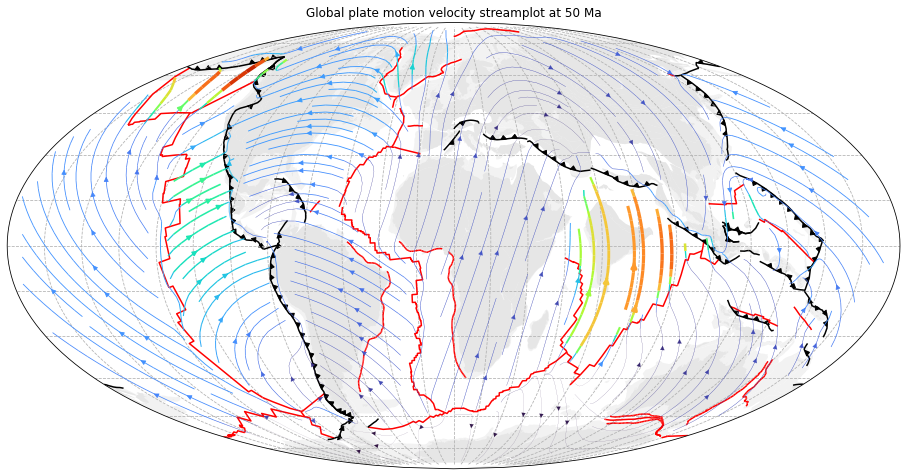

In [8]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12))
ax2 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
ax2.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.title('Global plate motion velocity streamplot at %i Ma' % (time))

# Plot all topologies
gplot.time = 50 # Ma
gplot.plot_continents(ax2, facecolor='0.95')
gplot.plot_coastlines(ax2, color='0.9')
gplot.plot_ridges_and_transforms(ax2, color='r')
gplot.plot_trenches(ax2, color='k')
gplot.plot_subduction_teeth(ax2, color='k')
ax2.set_global()

# Create the streamplot, using speed as a colormap.
speed = np.sqrt(u**2 + v**2)
S = ax2.streamplot(Xnodes,Ynodes,u,v,color=speed, transform=ccrs.PlateCarree(), 
                   linewidth=0.02*speed, cmap=plt.cm.turbo, density=2)
plt.show()

If you have moviepy, you can animate the motion of topological plates through geological time with a streamplot of domain point velocities (in cm/yr) overlying the plates. Let's reconstruct plate movements over 100 Ma in intervals of 10 Ma. 

Out of the four parameters we made: __Xnodes, Ynodes__ (the spatial extent of the velocity feature domain), __u and v__ (the east and north components of velocity), only u and v change with time. They are recalculated with each loop iteration.

As with the streamplot above, the Xnodes, Ynodes, u and v parameters are passed into `streamplot`.

In [9]:
# Set global extent (with 5-degree spacing) for the velocity feature domain
Xnodes = np.arange(-180,180,5)
Ynodes = np.arange(-90,90,5)

# Generate the meshnode point feature and flatten back into 1d lat-lon arrays
x,y = np.meshgrid(Xnodes,Ynodes)
x = x.flatten()
y = y.flatten()

# Time variables
oldest_seed_time = 100 # Ma
time_step = 10 # Ma

# Create a plot for each 10 Ma interval
for time in np.arange(oldest_seed_time,0.,-time_step):
    
    # Calculate velocity data at this time. Pass the flattened velocity feature domain.
    all_velocities = model.get_point_velocities(x, y, time, delta_time=1.0)
    
    # Extract the north and east velocity components and create u,v velocity components with them
    pt_vel_n=[]
    pt_vel_e=[]
    
    for vel in all_velocities:
        pt_vel_e.append(vel[1])
        pt_vel_n.append(vel[0])

    u = np.asarray(pt_vel_e).reshape((Ynodes.shape[0],Xnodes.shape[0]))
    v = np.asarray(pt_vel_n).reshape((Ynodes.shape[0],Xnodes.shape[0]))
    
    # Set up a GeoAxis plot
    fig = plt.figure(figsize=(16,12))
    ax2 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
    ax2.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
    plt.title('Global plate motion velocity streamplot at %i Ma' % (time))

    # Reconstruct topological plates and boundaries with PlotTopologies
    gplot.time = time # Ma
    gplot.plot_continents(ax2, facecolor='0.95')
    gplot.plot_coastlines(ax2, color='0.9')
    gplot.plot_ridges_and_transforms(ax2, color='r')
    gplot.plot_trenches(ax2, color='k')
    gplot.plot_subduction_teeth(ax2, color='k')
    ax2.set_global()
    
    # Create the streamplot, using speed as a colormap.
    speed = np.sqrt(u**2 + v**2)
    S = ax2.streamplot(Xnodes,Ynodes,u,v,color=speed, transform=ccrs.PlateCarree(), 
                       linewidth=0.02*speed, cmap=plt.cm.turbo, density=2)
    
    plt.savefig('/tmp/plate_velocity_stream_plot_%d_Ma.png' % time)
    plt.close()
    
    print('Image for %d Ma saved' % time)

Image for 100 Ma saved
Image for 90 Ma saved
Image for 80 Ma saved
Image for 70 Ma saved
Image for 60 Ma saved
Image for 50 Ma saved
Image for 40 Ma saved
Image for 30 Ma saved
Image for 20 Ma saved
Image for 10 Ma saved


MoviePy - Building file /tmp/plate_velocity_stream_plot.gif with imageio.


The movie will show up in a few seconds. Please be patient...


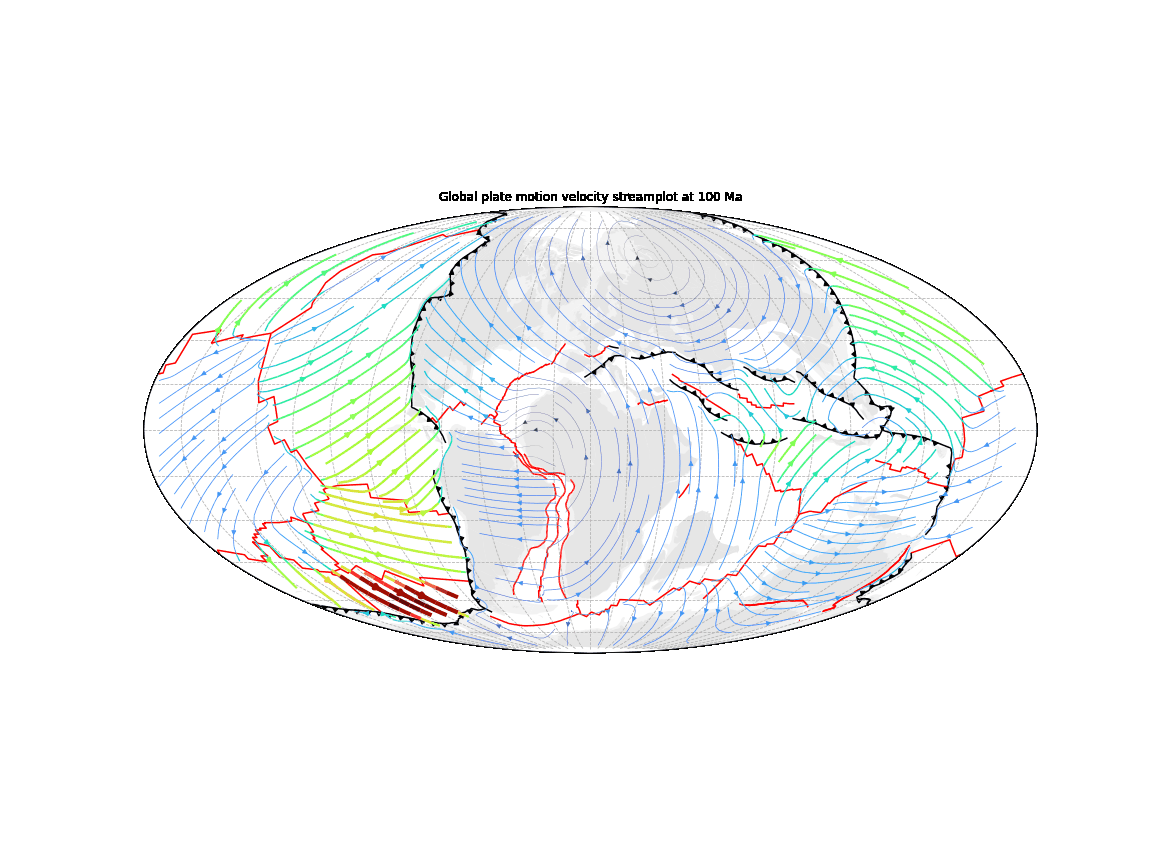

In [10]:
import moviepy.editor as mpy

frame_list = []

for time in np.arange(oldest_seed_time,0.,-time_step):
    frame_list.append('/tmp/plate_velocity_stream_plot_%d_Ma.png' % time)
    
clip = mpy.ImageSequenceClip(frame_list, fps=5)
clip.write_gif('/tmp/plate_velocity_stream_plot.gif')

from IPython.display import Image
print('The movie will show up in a few seconds. Please be patient...')
with open('/tmp/plate_velocity_stream_plot.gif','rb') as f:
    display(Image(data=f.read(), format='png', width = 3000, height = 1000))

### Example 2: Scatterplot

We can calculate plate velocities at every point in the velocity feature domain then colour-code their magnitudes on a scatterplot. 

Again, we will calculate the north and east components of velocity for each point on our velocity domain feature using `get_point_velocities`. We use matplotlib's `scatter` function for the scatterplot. It needs an array of latitudes and an array of longitudes to plot point data on. These will be __x and y__, the coordinates of points on our velocity domain feature. 

In [11]:
# The distribution of points in the velocity domain feature: set global extent with 5 degree intervals
Xnodes = np.arange(-180,180,5)
Ynodes = np.arange(-90,90,5)

# Create a lat-lon mesh and convert to 1d lat-lon arrays
x, y = np.meshgrid(Xnodes,Ynodes)
x = x.flatten()
y = y.flatten()

# Set a reconstruction time
time = 50 #ma

# Use GPlately to calculate north & east velocity components
domain_pt_velocities = model.get_point_velocities(x, y, time)

# Obtain the magnitude of each point's velocity using these x,y components
pt_vel_mags = []
for vel in domain_pt_velocities:
    pt_vel_mags.append(np.hypot(vel[0], vel[1]))

We plot the velocity domain feature points (in `x` and `y`) on a scatterplot below using their velocity magnitudes as a colour scale. 

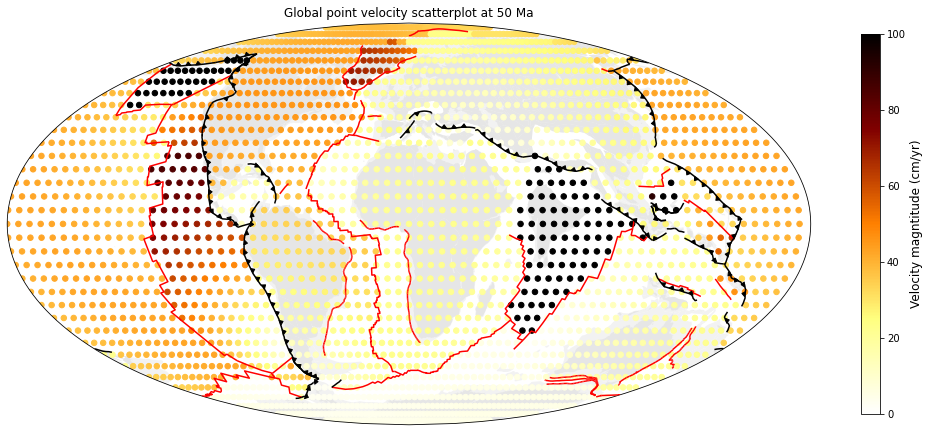

In [12]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(18,14))
ax3 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
plt.title('Global point velocity scatterplot at %i Ma' % (time))

# Plot all topologies reconstructed to 50Ma
gplot.time = 50 # Ma
gplot.plot_continents(ax3, facecolor='0.95')
gplot.plot_coastlines(ax3, color='0.9')
gplot.plot_ridges_and_transforms(ax3, color='r', zorder=3)
gplot.plot_trenches(ax3, color='k', zorder=3)
gplot.plot_subduction_teeth(ax3, color='k', zorder=3)

# Plot the velocity domain points with their velocity magnitudes as a colour scale.
im = ax3.scatter(x, y, transform=ccrs.PlateCarree(),c=pt_vel_mags,s=30,cmap=plt.cm.afmhot_r,vmin=0,vmax=100, zorder=2)

# Add colorbar, set global extent and show plot
fig.colorbar(im, ax=ax3,shrink=0.5).set_label('Velocity magntitude (cm/yr)',fontsize=12)
ax3.set_global()
plt.show()

If you have moviepy, you can animate the motion of topological plates through geological time with a scatterplot of domain point velocities (in cm/yr) overlying the plates. Let's reconstruct plate movements from 0-100Ma in intervals of 10 Ma. With each iteration of the time loop we re-calculate velocity data.

In [13]:
# Time variables
oldest_seed_time = 100 # Ma
time_step = 10 # Ma

# Create a plot for each 10 Ma interval
for time in np.arange(oldest_seed_time,0.,-time_step):
    
    # Call the GPlately function to get point velocities; do this for each time interval
    domain_pt_velocities = model.get_point_velocities(x, y, time, delta_time=1.0) 
    
    # The magnitude of each point's velocity is the hypotenuse of the north and east velocity components
    pt_vel_mags = []
    for vel in domain_pt_velocities:
        pt_vel_mags.append(np.hypot(vel[0], vel[1]))
    
    # Set up a GeoAxis plot
    fig = plt.figure(figsize=(18,14))
    ax3 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
    plt.title('Global point velocity scatterplot at %i Ma' % (time))

    # Plot all topologies reconstructed to the current Ma
    gplot.time = time # Ma
    gplot.plot_continents(ax3, facecolor='0.95')
    gplot.plot_coastlines(ax3, color='0.9')
    gplot.plot_ridges_and_transforms(ax3, color='r', zorder=3)
    gplot.plot_trenches(ax3, color='k', zorder=3)
    gplot.plot_subduction_teeth(ax3, color='k', zorder=3)

    # Plot the velocity domain points with their velocity magnitudes as a colour scale.
    im = ax3.scatter(x, y, transform=ccrs.PlateCarree(),c=pt_vel_mags,s=30,cmap=plt.cm.afmhot_r,vmin=0,vmax=100,
                     zorder=2)

    # Add colorbar, set global extent and show plot
    fig.colorbar(im, ax=ax3,shrink=0.5).set_label('Velocity magntitude (cm/yr)',fontsize=12)
    ax3.set_global()
    plt.savefig('/tmp/plate_velocity_scatter_plot_%d_Ma.png' % time)
    plt.close()
    
    print('Image for %d Ma saved' % time)

Image for 100 Ma saved
Image for 90 Ma saved
Image for 80 Ma saved
Image for 70 Ma saved
Image for 60 Ma saved
Image for 50 Ma saved
Image for 40 Ma saved
Image for 30 Ma saved
Image for 20 Ma saved
Image for 10 Ma saved


MoviePy - Building file /tmp/plate_velocity_scatter_plot.gif with imageio.


The movie will show up in a few seconds. Please be patient...


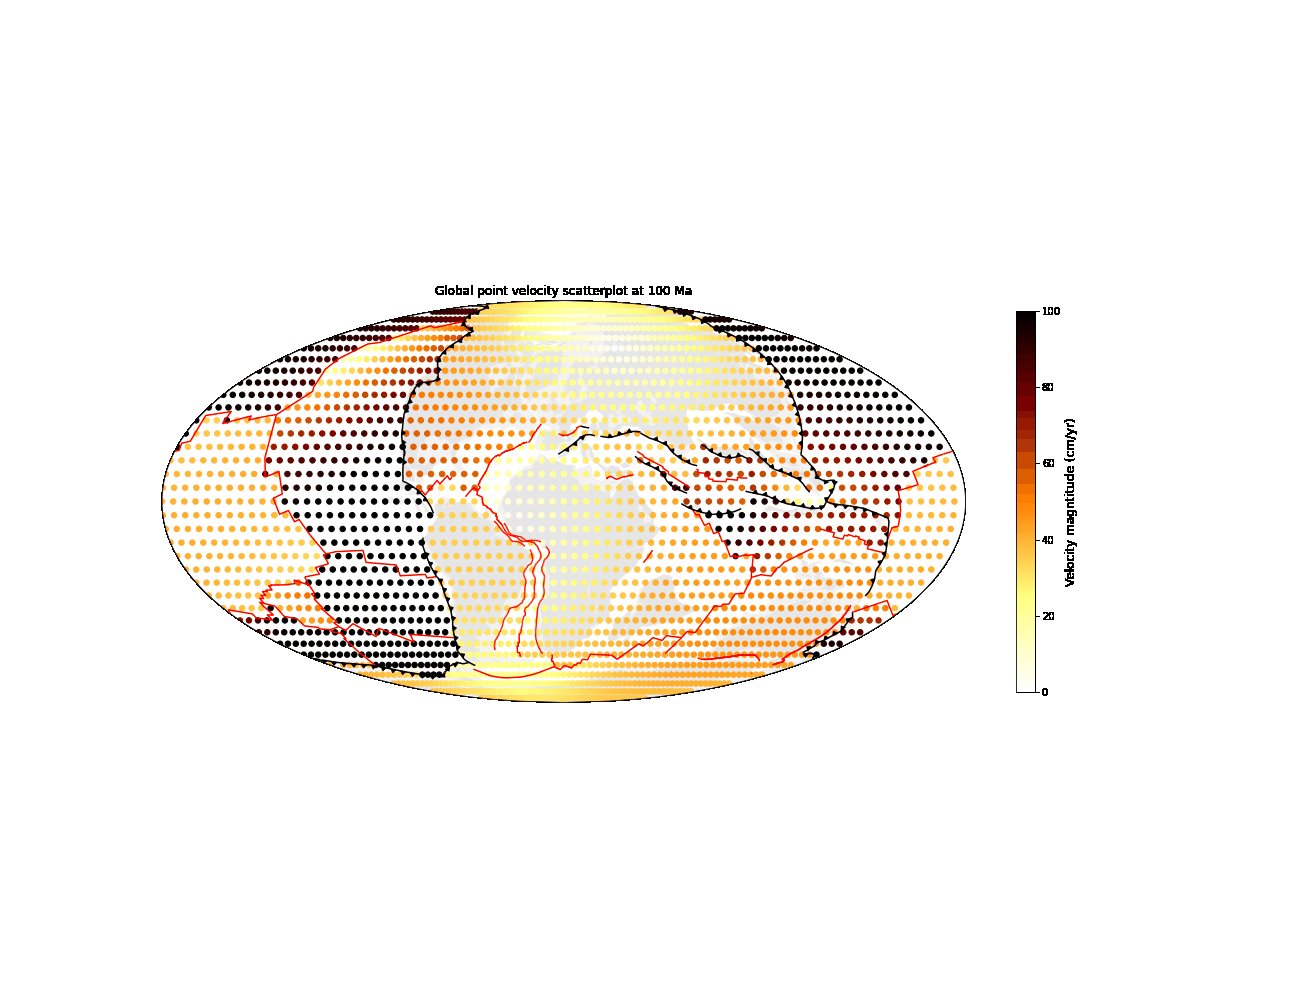

In [14]:
import moviepy.editor as mpy

frame_list = []

for time in np.arange(oldest_seed_time,0.,-time_step):
    frame_list.append('/tmp/plate_velocity_scatter_plot_%d_Ma.png' % time)
    
clip = mpy.ImageSequenceClip(frame_list, fps=5)
clip.write_gif('/tmp/plate_velocity_scatter_plot.gif')

from IPython.display import Image
print('The movie will show up in a few seconds. Please be patient...')
with open('/tmp/plate_velocity_scatter_plot.gif','rb') as f:
    display(Image(data=f.read(), format='png', width = 2000, height = 1000))